## Summary

Starting a new repo for collaboration with Kyle.  First I'm just adding the core code for doing basic simulations, including the big 1D protocols, 1D duffing system, and ND Langevin Dynamics.  Also including basic 2D harmonic oscillator system and simple protocols, previously just in another notebook.

Will add more to this repo as further functionality is updated and cleaned up.

---
## Imports for whole notebook

In [14]:
import sys
infoenginessims_path = ".."
# sys.path.append('~/Project/source/')
sys.path.append('~/Project/source/simtools')
sys.path.insert(0, infoenginessims_path)
# print()
from infoenginessims.api import *

from infoenginessims.integrators import rkdeterm_eulerstoch
from infoenginessims.dynamics import langevin_underdamped, langevin_overdamped
from infoenginessims.state_distributions import sd_tools, state_distribution

from infoenginessims import simulation
from infoenginessims.simprocedures import basic_simprocedures as sp
from infoenginessims.simprocedures import running_measurements as rp

from infoenginessims import analysis
import infoenginessims.analysis.state_dists_1D
import infoenginessims.analysis.running_quantities
import infoenginessims.analysis.hists_1D
import infoenginessims.analysis.protocols
import infoenginessims.analysis.animations


# %matplotlib inline

In [28]:
#kyles tools and systems#
# sys.path.append('~/Project/source/sus')
protocol_designer_path = "../../sus/library/"
sus_path = "../../sus/"
sys.path.insert(0, protocol_designer_path)
sys.path.insert(0, sus_path)

import bit_flip_protocols as bfp
quick_flip = bfp.bf_1D


import protocol_designer as prd
from protocol_designer import system as syst

the parameters:  [(1, 1), (-8, -8)]


---
## 1D Example

In [29]:
import infoenginessims.analysis.infospace_1D

In [31]:
system = quick_flip
total_t = 100.

# protocol = erasure_efficient.ErasureEfficient(total_t=total_t)

(<AxesSubplot:title={'center':'t=0.00'}>,
 [<matplotlib.lines.Line2D at 0x7f9c7260ea30>])

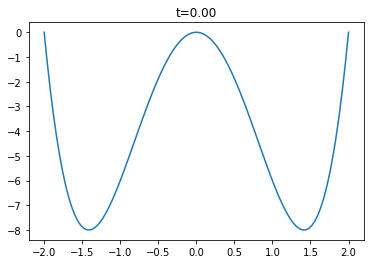

In [32]:
system.show_potential(0)

In [33]:
theta = 1.0
gamma = 1.0
eta = 1.0

state_shape = (2,)

mass = 1 / theta
kappa = eta**2 / (gamma * theta)

dynamic = langevin_underdamped.LangevinUnderdamped(
                theta, gamma, eta, system.get_external_force)

In [34]:
integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

In [35]:
get_initial_potential = lambda x: system.potential.potential(x, system.protocol.get_params(0))

In [36]:
%%time
initial_dist = sd_tools.make_1DUD_metastable_dist(
                    get_initial_potential, mass, kappa)

Optimization terminated successfully.
         Current function value: -8.000000
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -8.000000
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 6
CPU times: user 39 ms, sys: 6.6 ms, total: 45.6 ms
Wall time: 45.6 ms


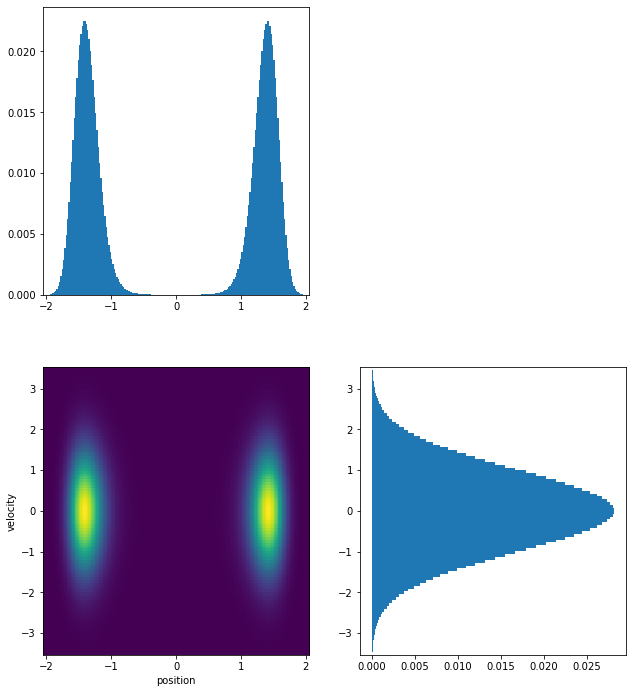

In [37]:
analysis.state_dists_1D.full_plot(initial_dist)

In [ ]:
# alpha = 7.
# zeta = 3.

# system = duffing.Duffing(protocol, alpha, zeta, has_velocity=False)

# get_initial_potential = lambda x: system.get_potential(x, 0)

# omega = 1.0
# xi = 1.0

# state_shape = ()

# kappa = omega / (xi**2)

# dynamic = langevin_overdamped.LangevinOverdamped(omega, xi, system.get_external_force)

# initial_dist = sd_tools.make_1DOD_metastable_dist(get_initial_potential, kappa)

# plt.plot(initial_dist.bins[0][:-1], initial_dist.probs)

In [38]:
%%time
ntrials = 50_000

initial_state = initial_dist.get_sample(ntrials)

CPU times: user 14 ms, sys: 2.01 ms, total: 16 ms
Wall time: 14.7 ms


In [39]:
np.shape(initial_state)

(50000, 2)

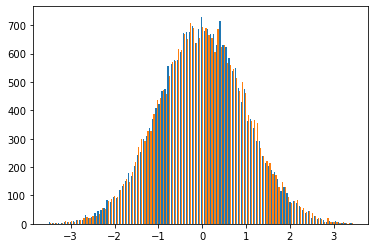

In [40]:
plt.hist(initial_state[25000:,:], bins=100);

In [41]:
procedures = [
              sp.ReturnFinalState(),
              sp.MeasureAllState(trial_request=slice(0, None)),  
              rp.MeasureAllValue(rp.get_dW, 'all_W'),
              rp.MeasureFinalValue(rp.get_dW, 'final_W'),
             ]

In [42]:
nsteps = 5_000

total_t = system.protocol.total_t

dt = total_t / nsteps

sim = simulation.Simulation(integrator.update_state, procedures, nsteps, dt,
                            initial_state, initial_dist, ntrials)

sim.system = system

AttributeError: 'Compound_Protocol' object has no attribute 'total_t'

In [58]:
%%time

sim.output = sim.run(verbose=True)

CPU times: user 1min 28s, sys: 4.84 s, total: 1min 33s
Wall time: 1min 34s


In [59]:
all_state = sim.output.all_state['states']
all_W = sim.output.all_W
final_W = sim.output.final_W

In [60]:
all_state.shape

(50000, 5001, 2)

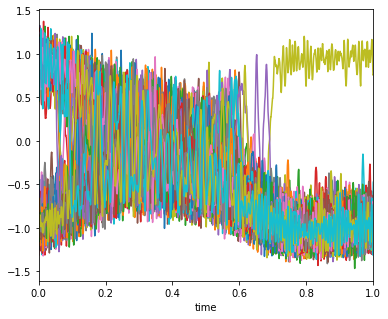

In [61]:
analysis.running_quantities.plot_running_quantity(all_state[:100,:,0])

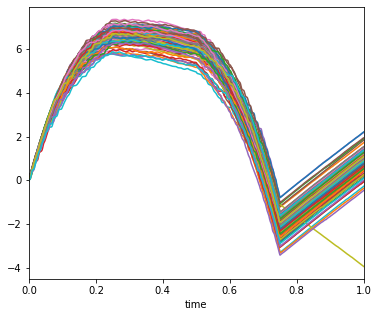

In [62]:
analysis.running_quantities.plot_running_quantity(all_W[:100])

In [63]:
np.mean(final_W)

0.6840642646569213

(<Figure size 432x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1084d67910>)

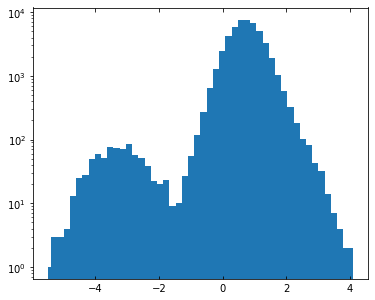

In [64]:
final_W_hist = np.histogram(final_W, bins=50)
analysis.hists_1D.plot_hist(final_W_hist, log=True)

In [65]:
infoenginessims_path = "../.."
sys.path.insert(0, infoenginessims_path)

from system_experiments import kyle_tools as kt

naive jarzynski: average of exp -Beta W is 1.061156749297115
binned jarzynski: binned average of exp -Beta W using only values of work where we have +W and -W realizations: 0.9035397893553467


../../system_experiments/kyle_tools.py:486: RuntimeWarning: divide by zero encountered in true_divide
  log_ratio = np.log(np.divide(pos_counts, neg_counts))
../../system_experiments/kyle_tools.py:486: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(np.divide(pos_counts, neg_counts))


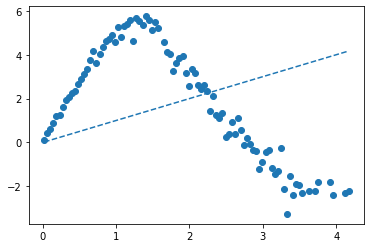

In [66]:
w, lr = kt.crooks_analysis_tsp(final_W, nbins=100)

In [67]:
np.mean(np.exp(-final_W))

1.061156749297115

In [69]:
lr

array([ 0.11937232,  0.42566782,  0.60703106,  0.87692966,  1.21438769,
        1.27091229,  1.59311494,  1.95234104,  2.05852364,  2.23517826,
        2.34677917,  2.65363678,  2.89433216,  3.11819916,  3.34802262,
        3.74254174,  4.14958069,  3.61459664,  4.02165027,  4.3425678 ,
        4.64246597,  4.71145884,  4.898518  ,  4.59078145,  5.27665587,
        4.81462041,  5.31730267,  5.37989735,  5.59842196,  4.62279179,
        5.66988092,  5.5174529 ,  5.36908644,  5.75257264,  5.6002721 ,
        5.10796364,  5.48686947,  5.20948615,         inf,  4.59174717,
        4.11496385,  4.02087741,  3.2470467 ,  3.61630876,  3.86423234,
        3.94481283,  3.15273602,  2.57587843,  3.33220451,  3.15700042,
        2.63905733,  2.42774824,  2.62103882,  2.35137526,  1.45225233,
        2.12823171,  1.26851133,  1.13140211,  1.35812348,  0.25131443,
        0.40546511,  0.94446161,  0.40546511,  1.09861229,  0.58778666,
       -0.12516314,  0.22314355, -0.08701138, -0.35667494, -0.37

---
### Example 2D System

In [ ]:
from infoenginessims.protocols.simple_linear_protocol import SimpleLinearProtocol
from infoenginessims.systems.harmonic_2D import Harmonic2D

In [ ]:
param_initial_vals = [1., 1., 0., 0., 0.]
param_final_vals = [1., 1., 1., 1., 1.]

total_t = 1000.

protocol = SimpleLinearProtocol(param_initial_vals, param_final_vals, total_t)

In [ ]:
spring_const0_scale = 1.
spring_const1_scale = 1.
center0_scale = 1.
center1_scale = 1.
min_height_scale = 1.

has_velocity = True

system = Harmonic2D(protocol,
                    spring_const0_scale, spring_const1_scale,
                    center0_scale, center1_scale, min_height_scale,
                    has_velocity=has_velocity)

In [ ]:
t = total_t * 1

nxbins = 100
X = np.linspace(-1.5, 1.5, nxbins)

U = np.empty(shape=(nxbins, nxbins))
F0 = np.empty(shape=(nxbins, nxbins))
F1 = np.empty(shape=(nxbins, nxbins))
for (i, x), (j, y) in product(enumerate(X), repeat=2):
    
    state = np.array([x, y])
    potential = system.get_potential(state, t, False)
    force = system.get_external_force(state, t, False)
#     print(force)
    
    U[i, j] = potential
    F0[i, j] = force[..., 0]
    F1[i, j] = force[..., 1]
    
extent = (X[0], X[1], X[0], X[1])

fig, ax = plt.subplots()
im = ax.imshow(U.transpose()[::-1,:], extent=extent)
colorbar = plt.colorbar(im)

fig, ax = plt.subplots()
im = ax.imshow(F0.transpose()[::-1,:], extent=extent)
colorbar = plt.colorbar(im)

fig, ax = plt.subplots()
im = ax.imshow(F1.transpose()[::-1,:], extent=extent)
colorbar = plt.colorbar(im)

In [ ]:
if has_velocity:

    theta = 1.
    gamma = 1.
    eta = 1.

    dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta,
                                                       system.get_external_force)
    
else:
    
    omega = 1.
    xi = 1.
    
    dynamic = langevin_overdamped.LangevinOverdamped(omega, xi,
                                                     system.get_external_force)

In [ ]:
integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

In [ ]:
ntrials = 100
posvel_dim = 2 if has_velocity else 1

initial_state = np.zeros((ntrials, 2, posvel_dim))

In [ ]:
procedures = [
              sp.ReturnFinalState(),
              sp.MeasureAllState(trial_request=slice(0, 100)),  
              rp.MeasureAllValue(rp.get_dW, 'all_W'),
              rp.MeasureFinalValue(rp.get_dW, 'final_W'),
             ]

In [ ]:
nsteps = 10_000

total_time = system.protocol.total_time

dt = total_time / nsteps

sim = simulation.Simulation(integrator.update_state, procedures, nsteps, dt,
                            initial_state)

sim.system = system

In [ ]:
%%time

sim.output = sim.run()

In [ ]:
all_state = sim.output.all_state['states']
all_W = sim.output.all_W
final_W = sim.output.final_W

In [ ]:
all_state.shape

In [ ]:
end_plot_time = total_time #* 1 / 100
trial_indices = np.s_[:100]

analysis.running_quantities.plot_running_quantity(all_state[trial_indices, :, 0, 0],
                                                  final_time=total_t,
                                                  end_plot_time=end_plot_time)

analysis.running_quantities.plot_running_quantity(all_state[trial_indices, :, 0, 1],
                                                  final_time=total_t,
                                                  end_plot_time=end_plot_time)

analysis.running_quantities.plot_running_quantity(all_state[trial_indices, :, 1, 0],
                                                  final_time=total_t,
                                                  end_plot_time=end_plot_time)

analysis.running_quantities.plot_running_quantity(all_state[trial_indices, :, 1, 1],
                                                  final_time=total_t,
                                                  end_plot_time=end_plot_time)

In [ ]:
analysis.running_quantities.plot_running_quantity(all_W[trial_indices],
                                                  final_time=total_t,
                                                  end_plot_time=end_plot_time)

In [7]:
final_W_hist = np.histogram(final_W, bins=50)
analysis.hists_1D.plot_hist(final_W_hist, log=True)

NameError: name 'final_W' is not defined

In [6]:
analysis.animations

NameError: name 'final_W' is not defined